In [1]:

import numpy as np
from scipy.signal import square  # For square pulse train generation
import os, sys
sys.path.append(r'D:\installed_GIT\git_proj\ASE-source-for-L-band') # this repository contain pyfiberamp

# %matplotlib inline
import matplotlib.pyplot as plt

from pyfiberamp.dynamic import DynamicSimulation
from pyfiberamp.fibers import YbDopedFiber
from pyfiberamp.helper_funcs import dynamic_time_coordinates

In [2]:
from pyfiberamp.spectroscopies import Spectroscopy

# for erbium fiber L spectrum

path_to_absorption_cross_section_file = 'erbium absorption cross sections.dat' # replace with your own file
path_to_emission_cross_section_file = 'erbium emission cross sections.dat' # replace with your own file
upper_state_lifetime = 1e-3
yb_spectroscopy = Spectroscopy.from_files(
    absorption_cross_section_file=path_to_absorption_cross_section_file,
    emission_cross_section_file=path_to_emission_cross_section_file,
    upper_state_lifetime=upper_state_lifetime,
    interpolate='spline') # alternatively: interpolate='linear'

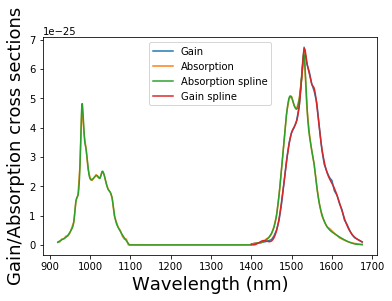

In [3]:
yb_spectroscopy.plot_gain_and_absorption_spectrum()

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          8.06e-03       8.03e-22          20             20       
       2          1.82e-05       2.69e-25          40             10       
       3          5.13e-06       3.99e-25          50              0       
Solved in 3 iterations, number of nodes 50. 
Maximum relative residual: 5.13e-06 
Maximum boundary residual: 3.99e-25


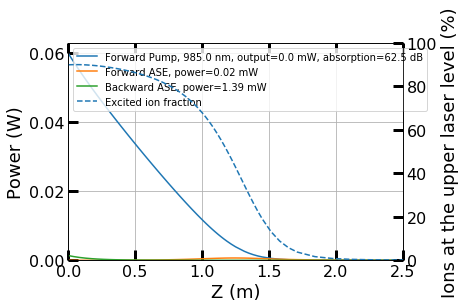

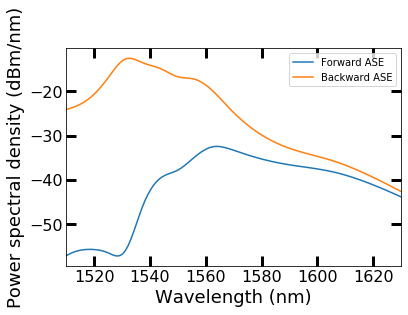

In [4]:
from pyfiberamp.steady_state import SteadyStateSimulation
from pyfiberamp.fibers import YbDopedFiber

Er_number_density = 3.7e25  # meter^-3  5e24
core_radius = 1.5e-6  # meter 
length_doped_fiber = 2.5 # meter  1.2
core_na = 0.2

start_ASE = 1510e-9
end_ASE = 1630e-9
power_pump = 60e-3

# Creating fiber with specified parameters
fiber = YbDopedFiber(length=length_doped_fiber,   # fiber length
                    core_radius=core_radius,    # core radius
                    ion_number_density=Er_number_density,   # Ion concentration 
                    background_loss=0.03,  # Linear core loss 15 db/km 
                                           # (the loss will be 0.03 of the transmitted radiation per meter)
                    core_na=core_na)       # Numerical aperture of the core               
simulation = SteadyStateSimulation()
simulation.fiber = fiber
# simulation.add_cw_signal(wl=985e-9, power=1e-3) # Passing a signal with these parameters through an erbium fiber

simulation.add_forward_pump(wl=985e-9, power=power_pump) # forward pumping with specified parameters
simulation.add_ase(wl_start=start_ASE, wl_end=end_ASE, n_bins=120) # Adding ASE parameters to sources
# 1510-1640
result = simulation.run(tol=1e-5)
result.plot_amplifier_result()

In [5]:
import matplotlib.pyplot as plt

haved_result = result.make_result_dict()

forward_ase = haved_result.get('forward_ase')
output_pow_forward_ase = forward_ase.get('output_powers') 
gain_forward_ase = forward_ase.get('gain')

backward_ase = haved_result.get('backward_ase')
output_pow_backward_ase = backward_ase.get('output_powers') 
gain_backward_ase = backward_ase.get('gain')

start_ASE, end_ASE

(1.51e-06, 1.63e-06)

In [6]:
def to_db(x):
    """Transforms a quantity to decibels."""
    return 10 * np.log10(x)


def to_dbm(power):
    """Transforms a power in Watts to dBm."""
    return to_db(power * 1000)


ase_wls_nm = np.linspace(start_ASE*1e9, end_ASE*1e9, int((end_ASE-start_ASE)*1e9)) # [5:-5]
print(len(ase_wls_nm))

ase_wl_step = ase_wls_nm[1] - ase_wls_nm[0]
output_pow_forward_ase_DBM = to_dbm(output_pow_forward_ase / ase_wl_step)
output_pow_backward_ase_DBM = to_dbm(output_pow_backward_ase / ase_wl_step)

120


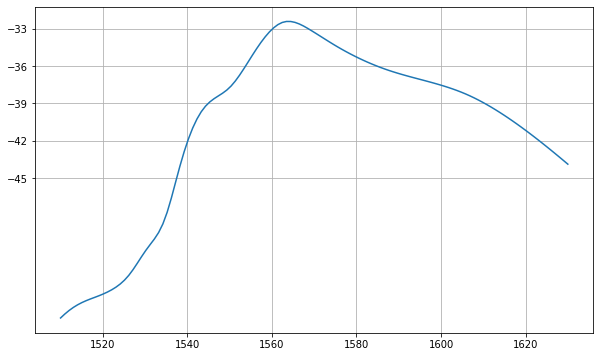

In [7]:
# result_spec = (output_pow_forward_ase_DBM + output_pow_backward_ase_DBM) / 2
degree = length_doped_fiber ** 1.2
devisor = abs(max(output_pow_forward_ase_DBM) - max(output_pow_backward_ase_DBM))**degree
output_pow_sum_ase = output_pow_forward_ase + (output_pow_backward_ase) / devisor
output_pow_sum_ase_DBM = to_dbm(output_pow_sum_ase / ase_wl_step)
plt.figure(figsize=(10, 6))
plt.yticks(np.arange(-45, 0, 3))
# plt.ylim((-35, -9))
plt.plot(ase_wls_nm, output_pow_sum_ase_DBM, label='Forward ASE')
plt.grid()

In [8]:
#  in linear values


# plt.figure(figsize=(10, 6))
# plt.plot(ase_wl_nm, output_pow_forward_ase)
# plt.plot(ase_wl_nm, output_pow_backward_ase)
# plt.grid()

In [9]:
# final output spectral density

output_signal = haved_result.get('forward_signal')
output_signal = output_signal.get('output_powers')

ase_wls_nm = np.linspace(start_ASE*1e9, end_ASE*1e9, len(output_signal)) # [5:-5]  len(output_signal) 
ase_wl_step = ase_wls_nm[1] - ase_wls_nm[0]
output_signal_DBM = to_dbm(output_signal / ase_wl_step)

plt.figure(figsize=(10, 6))
plt.plot(ase_wls_nm, output_signal_DBM, label='output signals ASE')
plt.legend()
plt.grid()
plt.show()
# print(output_signal)

AttributeError: 'NoneType' object has no attribute 'get'